In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from math import sqrt

### Time Series Regression - acousticness

In [24]:
data = pd.read_csv("dataset/data.csv")

In [47]:
# dropeamos las columnas que no necesitamos
data_ac = data.drop(columns=["valence", "danceability", "energy","instrumentalness","liveness","speechiness","artists","duration_ms","explicit","id","key","loudness","mode","name","popularity","release_date","tempo"])

In [48]:
data_ac["year"]=pd.to_datetime(data_ac["year"], format='%Y', errors='ignore')
data_ac["year"]

0        1921-01-01
1        1921-01-01
2        1921-01-01
3        1921-01-01
4        1921-01-01
            ...    
170648   2020-01-01
170649   2020-01-01
170650   2020-01-01
170651   2020-01-01
170652   2020-01-01
Name: year, Length: 170653, dtype: datetime64[ns]

In [49]:
# Ponemos la serie temporal como índice
data_ac.index = data_ac["year"]
data_ac.head(5)

,year,acousticness
year,,
1921-01-01,1921-01-01,0.982
1921-01-01,1921-01-01,0.732
1921-01-01,1921-01-01,0.961
1921-01-01,1921-01-01,0.967
1921-01-01,1921-01-01,0.957


In [50]:
### Dropeamos la columna year ya que la tenemos como índice
data_ac_s = data_ac.drop(columns=["year"])
data_ac_s.head(5)

,acousticness
year,
1921-01-01,0.982
1921-01-01,0.732
1921-01-01,0.961
1921-01-01,0.967
1921-01-01,0.957


In [54]:
# hacemos un groupby por año y media
data_ac_s_m=data_ac_s.groupby(['year']).mean()

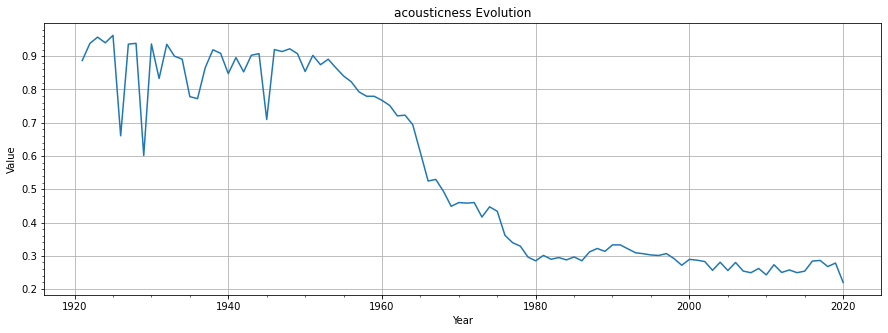

In [55]:
# hacemos un plot para ver la evolución de la variable
plt.figure(figsize=(15,5))
plt.grid()
plt.minorticks_on()
plt.plot(data_ac_s_m)
plt.xlabel('Year') 
plt.ylabel('Value')
plt.title("Acousticness Evolution");

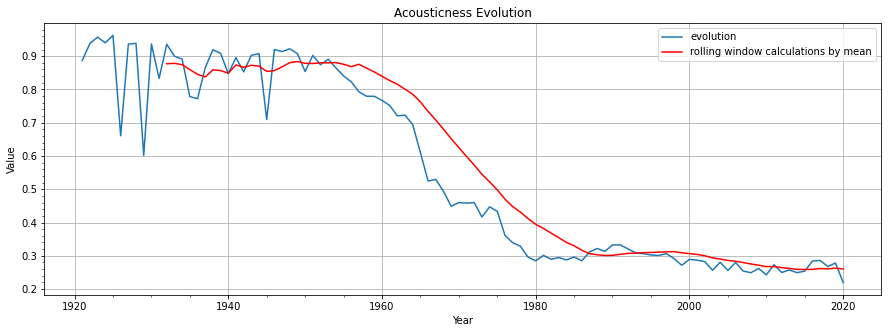

In [63]:
# hacemos un plot para ver la evolución de la variable con un rolling window calculations por la media.
plt.figure(figsize=(15,5))
plt.grid()
plt.minorticks_on()
plt.plot(data_ac_s_m, label="evolution")
plt.plot(data_ac_s_m.rolling(window=12).mean(), c="r", label="rolling window calculations by mean")
plt.xlabel('Year') 
plt.ylabel('Value')
plt.legend()
plt.title("Acousticness Evolution");

In [58]:
# mediante la libreria statsmodels, hacemos un seasonal_decompose para separar la estacionalidad , tendencia y el resid
res=seasonal_decompose(data_ac_s_m, model="additive")

<Figure size 720x504 with 0 Axes>

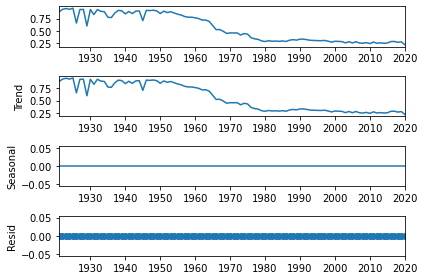

In [60]:
# lo graficamos
plt.figure(figsize=(10,7))
res.plot();

### Time Series Forecasting - ARIMA

In [64]:
from statsmodels.tsa.arima.model import ARIMA

In [65]:
model = ARIMA(data_ac_s_m, order=(5,1,0))
model_fit = model.fit()

/Users/borjadelrio/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/borjadelrio/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/borjadelrio/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


In [66]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           acousticness   No. Observations:                  100
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 135.618
Date:                Tue, 15 Dec 2020   AIC                           -259.236
Time:                        13:43:05   BIC                           -243.666
Sample:                    01-01-1921   HQIC                          -252.936
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6274      0.089     -7.054      0.000      -0.802      -0.453
ar.L2         -0.3310      0.123     -2.692      0.007      -0.572      -0.090
ar.L3          0.0928      0.113      0.818      0.4

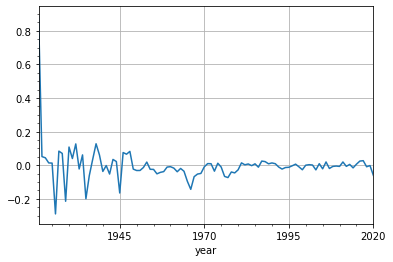

In [67]:
residuals = model_fit.resid
residuals.plot()
plt.grid()
plt.minorticks_on()
plt.show()

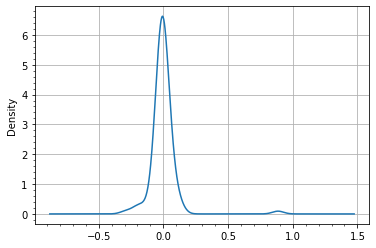

In [68]:
residuals.plot(kind='kde')
plt.grid()
plt.minorticks_on()
plt.show()

In [69]:
# hacemos un .describe para ver la media, desviación estándar
print(residuals.describe())

count    100.000000
mean      -0.001589
std        0.108347
min       -0.289503
25%       -0.028310
50%       -0.006863
75%        0.014077
max        0.886896
dtype: float64


### evaluate an ARIMA model using a walk-forward validation

In [71]:
# split into train and test sets
X = data_ac_s_m.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [72]:
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=0.286673, expected=0.311664
predicted=0.300306, expected=0.322010


/Users/borjadelrio/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


predicted=0.304656, expected=0.313351
predicted=0.318997, expected=0.332870
predicted=0.323710, expected=0.332765
predicted=0.331209, expected=0.320809
predicted=0.331783, expected=0.309069
predicted=0.319719, expected=0.306234
predicted=0.314508, expected=0.302512
predicted=0.303999, expected=0.301027
predicted=0.300007, expected=0.306716
predicted=0.300886, expected=0.291489
predicted=0.298234, expected=0.271590
predicted=0.288825, expected=0.289323
predicted=0.283366, expected=0.286842
predicted=0.280861, expected=0.282624
predicted=0.283837, expected=0.256471
predicted=0.270980, expected=0.280559
predicted=0.277145, expected=0.255764
predicted=0.259987, expected=0.279986
predicted=0.273183, expected=0.254081
predicted=0.256088, expected=0.249192
predicted=0.266609, expected=0.261929
predicted=0.249489, expected=0.242687
predicted=0.253394, expected=0.273183
predicted=0.256307, expected=0.249953
predicted=0.252263, expected=0.257488
predicted=0.264920, expected=0.249313
predicted=0.

### Evaluamos el forecast

In [73]:
# miramos el RMSE
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.018


### Hacemos el gráfico entre el forecast y el actual outcome

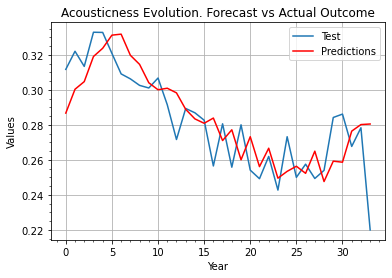

In [75]:
plt.plot(test, label="Test")
plt.plot(predictions, color='red', label="Predictions")
plt.grid()
plt.minorticks_on()
plt.xlabel('Year') 
plt.ylabel('Values')
plt.title("Acousticness Evolution. Forecast vs Actual Outcome");
plt.legend()